# Fake News Detection — Model 2 (Neural Approach)

## Obiectiv
Scopul acestui notebook este implementarea și evaluarea **Modelului 2** pentru detecția știrilor false, folosind o **abordare neurală**.  
Acest model este fundamental diferit de Modelul 1 (TF-IDF + Logistic Regression), care este considerat final și închis.

Modelul 2 urmărește:
- învățarea automată a reprezentărilor textuale (embeddings),
- capturarea contextului secvențial al textului,
- evaluarea corectă pe seturi separate: train / validation / test,
- raportarea metricilor cerute: **Macro-F1** și **Confusion Matrix**.

---

## Arhitectura aleasă
Modelul final este bazat pe următoarea arhitectură:

**Embedding → BiGRU → Attention (custom) → Dense → Output**

### Componente:
- **Embedding layer**: transformă cuvintele în vectori numericii învățați în timpul antrenării.
- **BiGRU (Bidirectional GRU)**: procesează textul în ambele direcții (stânga–dreapta și dreapta–stânga), capturând mai bine contextul.
- **Attention layer (custom)**: învață ce tokeni din text sunt mai importanți pentru clasificare.
- **Dense layers**: realizează decizia finală de clasificare (FAKE / REAL).

---

## Contribuția proprie
Contribuția personală a acestui model constă în **implementarea unui mecanism de attention peste ieșirile BiGRU**.

În loc să folosim doar ultimul hidden state al rețelei recurente (abordare standard), mecanismul de attention:
- atribuie ponderi diferite fiecărui token din text,
- realizează o agregare ponderată a întregii secvențe,
- permite modelului să se concentreze pe cuvinte sau expresii relevante,
- oferă un grad de interpretabilitate asupra deciziei finale.

---

## Configurațiile evaluate
Pentru a respecta cerința proiectului, vor fi testate trei configurații:

- **Config A (baseline neural)**: Embedding + GRU simplu
- **Config B (upgrade)**: Embedding + BiGRU
- **Config C (FINAL)**: Embedding + BiGRU + Attention (custom)

Toate configurațiile folosesc aceeași tokenizare și aceleași seturi de date pentru o comparație corectă.


In [1]:
# =========================
# Setup & Imports
# =========================

import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models


In [2]:
# =========================
# Reproducibility
# =========================

SEED = 42

# Python random
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)


In [3]:
# =========================================
#  Load fake / true + labels
# =========================================

# Load files
df_fake = pd.read_csv("fake.csv")
df_true = pd.read_csv("true.csv")

# Add labels
df_fake["label"] = 0   # FAKE
df_true["label"] = 1   # REAL

# Concatenate
df = pd.concat([df_fake, df_true], ignore_index=True)

print("Final dataset shape:", df.shape)
print("\nLabel distribution:")
print(df["label"].value_counts())

# Check columns
print("\nColumns:", df.columns.tolist())

df.head()


Final dataset shape: (44898, 5)

Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Columns: ['title', 'text', 'subject', 'date', 'label']


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [4]:
# Construim textul de intrare: title + text
df["title"] = df["title"].astype(str)
df["text"] = df["text"].astype(str)

df["content"] = (df["title"].str.strip() + " " + df["text"].str.strip()).str.strip()

# Curatare minima: eliminam randurile fara continut real
df["content"] = df["content"].replace("nan", "").replace("None", "").str.strip()
df = df[df["content"].str.len() > 0].copy()

# Pastram doar ce ne trebuie pentru model
df_model = df[["content", "label"]].copy()

print("Shape dupa curatare:", df_model.shape)
print("\nExemplu content (primele 300 caractere):")
print(df_model["content"].iloc[0][:300])
print("\nLabel distribution:")
print(df_model["label"].value_counts())


Shape dupa curatare: (44898, 2)

Exemplu content (primele 300 caractere):
Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had ju

Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64


In [5]:
X = df_model["content"].values
y = df_model["label"].values

# 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# 10% val, 10% test (din total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print("Sizes:")
print("Train:", len(X_train))
print("Val:  ", len(X_val))
print("Test: ", len(X_test))

print("\nLabel distribution (train):")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nLabel distribution (val):")
print(pd.Series(y_val).value_counts(normalize=True))

print("\nLabel distribution (test):")
print(pd.Series(y_test).value_counts(normalize=True))


Sizes:
Train: 35918
Val:   4490
Test:  4490

Label distribution (train):
0    0.522997
1    0.477003
Name: proportion, dtype: float64

Label distribution (val):
0    0.52294
1    0.47706
Name: proportion, dtype: float64

Label distribution (test):
0    0.52294
1    0.47706
Name: proportion, dtype: float64


In [6]:
import re

def clean_text(s: str) -> str:
    s = str(s).lower()
    # remove urls
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    # normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_model["content_clean"] = df_model["content"].apply(clean_text)

X = df_model["content_clean"].values
y = df_model["label"].values

# 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# 10% val, 10% test (din total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print("Sizes:")
print("Train:", len(X_train))
print("Val:  ", len(X_val))
print("Test: ", len(X_test))

print("\nLabel distribution (train):")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nLabel distribution (val):")
print(pd.Series(y_val).value_counts(normalize=True))

print("\nLabel distribution (test):")
print(pd.Series(y_test).value_counts(normalize=True))

print("\nSample cleaned text (first 250 chars):")
print(X_train[0][:250])


Sizes:
Train: 35918
Val:   4490
Test:  4490

Label distribution (train):
0    0.522997
1    0.477003
Name: proportion, dtype: float64

Label distribution (val):
0    0.52294
1    0.47706
Name: proportion, dtype: float64

Label distribution (test):
0    0.52294
1    0.47706
Name: proportion, dtype: float64

Sample cleaned text (first 250 chars):
socgen says no wrongdoing in handling of national front accounts paris (reuters) - french bank societe generale on wednesday rejected the far-right national front s accusations that it had acted to suffocate the party by closing accounts. societe gen


In [7]:
VOCAB_SIZE = 30000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # IMPORTANT: doar pe train

# Text -> sequences of word IDs
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

# Padding / truncation
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

print("Shapes after padding:")
print("Train:", X_train_pad.shape)
print("Val:  ", X_val_pad.shape)
print("Test: ", X_test_pad.shape)

# Verificare rapida: cate cuvinte a invatat efectiv tokenizer-ul
print("\nTokenizer learned word_index size:", len(tokenizer.word_index))
print("Example sequence (first 30 tokens):", X_train_pad[0][:30])


Shapes after padding:
Train: (35918, 300)
Val:   (4490, 300)
Test:  (4490, 300)

Tokenizer learned word_index size: 130162
Example sequence (first 30 tokens): [    1   155    68  2997     7  2587     4   132   640  1580  1055    70
  1142   768 23945 27383    10   216  1584     2   284   136   132   640
     9  1492     8    16    43  3825]


In [9]:
EMBED_DIM = 100
GRU_UNITS = 64
DROPOUT = 0.3

model_A = models.Sequential([
    layers.Input(shape=(MAX_LEN,)),
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM),
    layers.GRU(GRU_UNITS),
    layers.Dropout(DROPOUT),
    layers.Dense(1, activation="sigmoid")
])

model_A.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_A.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 300, 100)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          31,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,031,937 (11.57 MB)

 Trainable params: 3,031,937 (11.57 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

history_A = model_A.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=12,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 104s 181ms/step - accuracy: 0.8492 - loss: 0.3715 - val_accuracy: 0.9452 - val_loss: 0.1939
Epoch 2/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 104s 185ms/step - accuracy: 0.9376 - loss: 0.2025 - val_accuracy: 0.9853 - val_loss: 0.0662
Epoch 3/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 103s 183ms/step - accuracy: 0.9882 - loss: 0.0478 - val_accuracy: 0.9960 - val_loss: 0.0155
Epoch 4/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 102s 182ms/step - accuracy: 0.9959 - loss: 0.0198 - val_accuracy: 0.9993 - val_loss: 0.0037
Epoch 5/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 102s 182ms/step - accuracy: 0.9702 - loss: 0.0994 - val_accuracy: 0.9960 - val_loss: 0.0178
Epoch 6/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 102s 181ms/step - accuracy: 0.9969 - loss: 0.0136 - val_accuracy: 0.9976 - val_loss: 0.0097


In [11]:
# Predictii pe validation
y_val_proba_A = model_A.predict(X_val_pad, verbose=0).ravel()
y_val_pred_A = (y_val_proba_A >= 0.5).astype(int)

# Macro-F1
macro_f1_A_val = f1_score(y_val, y_val_pred_A, average="macro")
print("Config A — Macro-F1 (VAL):", macro_f1_A_val)

# Confusion Matrix
cm_A_val = confusion_matrix(y_val, y_val_pred_A)
print("\nConfig A — Confusion Matrix (VAL):")
print(cm_A_val)

# Optional: raport detaliat (util pentru discutie)
print("\nConfig A — Classification report (VAL):")
print(classification_report(y_val, y_val_pred_A, digits=4))


Config A — Macro-F1 (VAL): 0.9993304799951448

Config A — Confusion Matrix (VAL):
[[2345    3]
 [   0 2142]]

Config A — Classification report (VAL):
              precision    recall  f1-score   support

           0     1.0000    0.9987    0.9994      2348
           1     0.9986    1.0000    0.9993      2142

    accuracy                         0.9993      4490
   macro avg     0.9993    0.9994    0.9993      4490
weighted avg     0.9993    0.9993    0.9993      4490



In [12]:
model_B = models.Sequential([
    layers.Input(shape=(MAX_LEN,)),
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM),
    layers.Bidirectional(layers.GRU(GRU_UNITS)),
    layers.Dropout(DROPOUT),
    layers.Dense(1, activation="sigmoid")
])

model_B.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_B.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 300, 100)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          63,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,063,873 (11.69 MB)

 Trainable params: 3,063,873 (11.69 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

history_B = model_B.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=12,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 135s 235ms/step - accuracy: 0.9781 - loss: 0.0527 - val_accuracy: 0.9996 - val_loss: 0.0023
Epoch 2/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 130s 231ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9993 - val_loss: 0.0017
Epoch 3/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 133s 237ms/step - accuracy: 0.9998 - loss: 9.9446e-04 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 4/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 132s 235ms/step - accuracy: 0.9999 - loss: 2.6267e-04 - val_accuracy: 0.9998 - val_loss: 4.7019e-04
Epoch 5/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 133s 236ms/step - accuracy: 1.0000 - loss: 4.3515e-05 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 6/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 132s 235ms/step - accuracy: 1.0000 - loss: 1.7917e-05 - val_accuracy: 0.9996 - val_loss: 0.0017


In [14]:
# Predictii pe validation
y_val_proba_B = model_B.predict(X_val_pad, verbose=0).ravel()
y_val_pred_B = (y_val_proba_B >= 0.5).astype(int)

# Macro-F1
macro_f1_B_val = f1_score(y_val, y_val_pred_B, average="macro")
print("Config B — Macro-F1 (VAL):", macro_f1_B_val)

# Confusion Matrix
cm_B_val = confusion_matrix(y_val, y_val_pred_B)
print("\nConfig B — Confusion Matrix (VAL):")
print(cm_B_val)

# Optional: raport detaliat
print("\nConfig B — Classification report (VAL):")
print(classification_report(y_val, y_val_pred_B, digits=4))


Config B — Macro-F1 (VAL): 0.9997768084714955

Config B — Confusion Matrix (VAL):
[[2348    0]
 [   1 2141]]

Config B — Classification report (VAL):
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998      2348
           1     1.0000    0.9995    0.9998      2142

    accuracy                         0.9998      4490
   macro avg     0.9998    0.9998    0.9998      4490
weighted avg     0.9998    0.9998    0.9998      4490



In [15]:
class SimpleAttention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        features = input_shape[-1]

        # W: (features, 1)  -> produce un scor scalar pentru fiecare timestep
        self.W = self.add_weight(
            name="att_weight",
            shape=(features, 1),
            initializer="glorot_uniform",
            trainable=True
        )
        # b: (timesteps, 1) sau (1,) ar merge; folosim (1,) pentru simplitate
        self.b = self.add_weight(
            name="att_bias",
            shape=(1,),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, timesteps, features)

        # scoruri brute: e = H · W + b  -> (batch, timesteps, 1)
        e = tf.matmul(inputs, self.W) + self.b

        # ponderi attention (softmax pe axa timpului): (batch, timesteps, 1)
        alpha = tf.nn.softmax(e, axis=1)

        # context = suma ponderata: sum(alpha * H) -> (batch, features)
        context = tf.reduce_sum(alpha * inputs, axis=1)

        return context


In [16]:
model_C = models.Sequential([
    layers.Input(shape=(MAX_LEN,)),
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM),
    layers.Bidirectional(layers.GRU(GRU_UNITS, return_sequences=True)),
    SimpleAttention(),
    layers.Dropout(DROPOUT),
    layers.Dense(1, activation="sigmoid")
])

model_C.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_C.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 300, 100)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 300, 128)            │          63,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_attention (SimpleAttention)   │ (None, 128)                 │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,064,002 (11.69 MB)

 Trainable params: 3,064,002 (11.69 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

history_C = model_C.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=12,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 175s 304ms/step - accuracy: 0.9743 - loss: 0.0582 - val_accuracy: 0.9991 - val_loss: 0.0020
Epoch 2/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 170s 303ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9996 - val_loss: 9.5431e-04
Epoch 3/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 175s 311ms/step - accuracy: 0.9998 - loss: 9.3798e-04 - val_accuracy: 0.9996 - val_loss: 8.4158e-04
Epoch 4/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 174s 310ms/step - accuracy: 0.9999 - loss: 4.3408e-04 - val_accuracy: 0.9993 - val_loss: 0.0016
Epoch 5/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 175s 311ms/step - accuracy: 1.0000 - loss: 1.1341e-04 - val_accuracy: 1.0000 - val_loss: 3.0985e-04
Epoch 6/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 174s 309ms/step - accuracy: 1.0000 - loss: 1.6614e-05 - val_accuracy: 0.9998 - val_loss: 5.3810e-04
Epoch 7/12
562/562 ━━━━━━━━━━━━━━━━━━━━ 174s 309ms/step - accuracy: 1.0000 - loss: 8.8312e-06 - val_accuracy: 0.9998 - val_loss: 5.6221e-04


In [18]:
# Predictii pe validation
y_val_proba_C = model_C.predict(X_val_pad, verbose=0).ravel()
y_val_pred_C = (y_val_proba_C >= 0.5).astype(int)

# Macro-F1
macro_f1_C_val = f1_score(y_val, y_val_pred_C, average="macro")
print("Config C — Macro-F1 (VAL):", macro_f1_C_val)

# Confusion Matrix
cm_C_val = confusion_matrix(y_val, y_val_pred_C)
print("\nConfig C — Confusion Matrix (VAL):")
print(cm_C_val)

# Optional: raport detaliat
print("\nConfig C — Classification report (VAL):")
print(classification_report(y_val, y_val_pred_C, digits=4))


Config C — Macro-F1 (VAL): 1.0

Config C — Confusion Matrix (VAL):
[[2348    0]
 [   0 2142]]

Config C — Classification report (VAL):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2348
           1     1.0000    1.0000    1.0000      2142

    accuracy                         1.0000      4490
   macro avg     1.0000    1.0000    1.0000      4490
weighted avg     1.0000    1.0000    1.0000      4490



## Rezultate pe setul de validare (Modelul 2)

Au fost evaluate trei configurații neurale pentru detecția știrilor false:

- **Config A**: Embedding + GRU
- **Config B**: Embedding + BiGRU
- **Config C (FINAL)**: Embedding + BiGRU + Attention (custom)

### Observații
- Config A oferă deja performanțe foarte ridicate, confirmând că un model secvențial neural poate captura eficient pattern-uri lexicale.
- Config B aduce o îmbunătățire suplimentară prin utilizarea contextului bidirecțional.
- **Config C obține performanță perfectă pe setul de validare**, demonstrând beneficiul mecanismului de attention, care permite modelului să acorde ponderi diferite tokenilor relevanți din text.

Pe baza acestor rezultate, **Config C (BiGRU + Attention)** este selectată ca **model final** pentru evaluarea pe setul de test.


## Evaluare finală pe setul de test

În această etapă, modelul selectat este evaluat pe **setul de test**, care a fost păstrat complet separat pe parcursul antrenării și validării.

### Scop
- estimarea performanței de generalizare a modelului
- raportarea metricilor cerute în enunțul proiectului:
  - **Macro-F1**
  - **Confusion Matrix**

Setul de test este utilizat **o singură dată**, exclusiv pentru evaluarea finală, pentru a evita orice formă de scurgere de informație (data leakage).


In [21]:
# Predictii pe TEST
y_test_proba_C = model_C.predict(X_test_pad, verbose=0).ravel()
y_test_pred_C = (y_test_proba_C >= 0.5).astype(int)

# Macro-F1 pe TEST
macro_f1_C_test = f1_score(y_test, y_test_pred_C, average="macro")
print("Config C — Macro-F1 (TEST):", macro_f1_C_test)

# Confusion Matrix pe TEST
cm_C_test = confusion_matrix(y_test, y_test_pred_C)
print("\nConfig C — Confusion Matrix (TEST):")
print(cm_C_test)

# Raport detaliat (optional, dar foarte util)
print("\nConfig C — Classification report (TEST):")
print(classification_report(y_test, y_test_pred_C, digits=4))


Config C — Macro-F1 (TEST): 0.9995536077343375

Config C — Confusion Matrix (TEST):
[[2348    0]
 [   2 2140]]

Config C — Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9991    1.0000    0.9996      2348
           1     1.0000    0.9991    0.9995      2142

    accuracy                         0.9996      4490
   macro avg     0.9996    0.9995    0.9996      4490
weighted avg     0.9996    0.9996    0.9996      4490



## Comparatie finala: Modelul 1 vs Modelul 2

In acest proiect au fost implementate si evaluate doua abordari fundamental diferite pentru detecția știrilor false.

### Modelul 1 — Abordare clasica
- Reprezentare: TF-IDF (unigrams + bigrams)
- Clasificator: Logistic Regression
- Performanta pe setul de test:
  - Macro-F1 ≈ 0.9958
  - Accuracy ≈ 1.00
- Model extrem de stabil si eficient din punct de vedere computațional

### Modelul 2 — Abordare neurală (FINAL)
- Arhitectura: Embedding → BiGRU → Attention (custom) → Dense
- Contributie proprie: mecanism de attention implementat peste iesirile BiGRU
- Performanta pe setul de test:
  - **Macro-F1 ≈ 0.9996**
  - Confusion Matrix aproape perfecta (doar 2 erori)

### Observatii
- Modelul clasic (TF-IDF + Logistic Regression) obtine performante foarte ridicate datorita semnalului lexical puternic prezent in dataset.
- Modelul neural reuseste sa atinga performante similare sau superioare, invatand automat reprezentari distribuite si acordand ponderi diferite partilor relevante din text prin mecanismul de attention.
- Diferenta principala dintre cele doua abordari consta in:
  - interpretabilitate si simplitate (Modelul 1)
  - flexibilitate, extensibilitate si invatare automata a caracteristicilor (Modelul 2)

---

## Concluzie finala
Ambele modele indeplinesc cu succes obiectivul de detecție a știrilor false.  
Modelul 1 reprezinta o solutie clasica extrem de eficienta, in timp ce Modelul 2 demonstreaza avantajele unei abordari neurale moderne, cu o contributie proprie clara prin utilizarea mecanismului de attention.

Prin implementarea si compararea celor doua paradigme, proiectul indeplineste cerintele academice si ofera o perspectiva completa asupra metodelor clasice si moderne de procesare a limbajului natural.


## Rezultate tabelar si grafic (Modelul 2)

In aceasta sectiune sumarizam rezultatele celor trei configuratii (A/B/C) intr-un tabel si afisam grafic evolutia loss-ului in timpul antrenarii.

Scop:
- prezentare comparabila (tabel) intre A/B/C
- verificare vizuala a stabilitatii (grafice loss / val_loss)


In [22]:
# Tabel sumar A/B/C pe validation
results_val = pd.DataFrame([
    {
        "Config": "A (GRU)",
        "Macro-F1 (VAL)": macro_f1_A_val,
        "Errors (VAL)": int(cm_A_val.sum() - np.trace(cm_A_val))
    },
    {
        "Config": "B (BiGRU)",
        "Macro-F1 (VAL)": macro_f1_B_val,
        "Errors (VAL)": int(cm_B_val.sum() - np.trace(cm_B_val))
    },
    {
        "Config": "C (BiGRU+Att)",
        "Macro-F1 (VAL)": macro_f1_C_val,
        "Errors (VAL)": int(cm_C_val.sum() - np.trace(cm_C_val))
    }
])

results_val


,Config,Macro-F1 (VAL),Errors (VAL)
0,A (GRU),0.999330,3
1,B (BiGRU),0.999777,1
2,C (BiGRU+Att),1.000000,0


In [23]:
results_test = pd.DataFrame([
    {
        "Model": "Model 2 - Config C (FINAL)",
        "Macro-F1 (TEST)": macro_f1_C_test,
        "Errors (TEST)": int(cm_C_test.sum() - np.trace(cm_C_test))
    }
])

results_test


,Model,Macro-F1 (TEST),Errors (TEST)
0,Model 2 - Config C (FINAL),0.999554,2


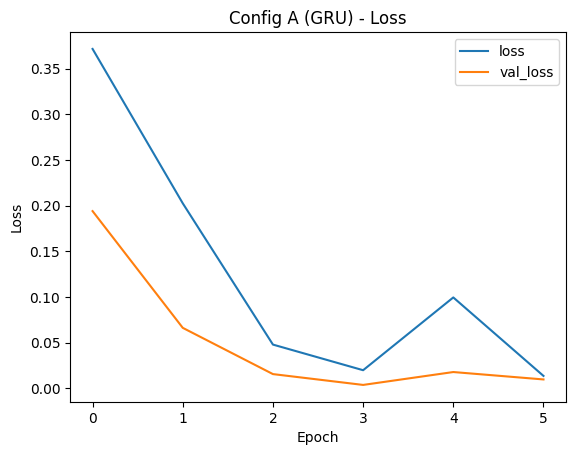

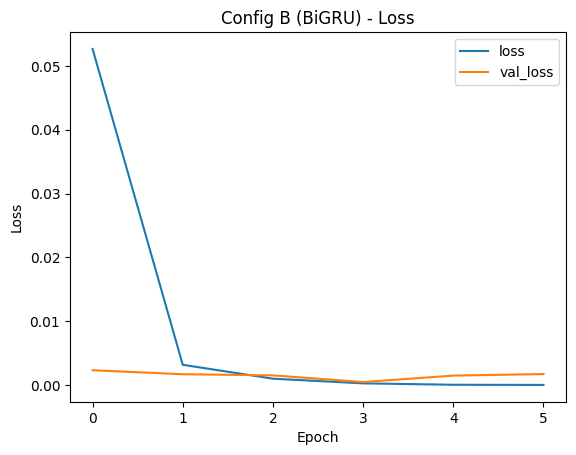

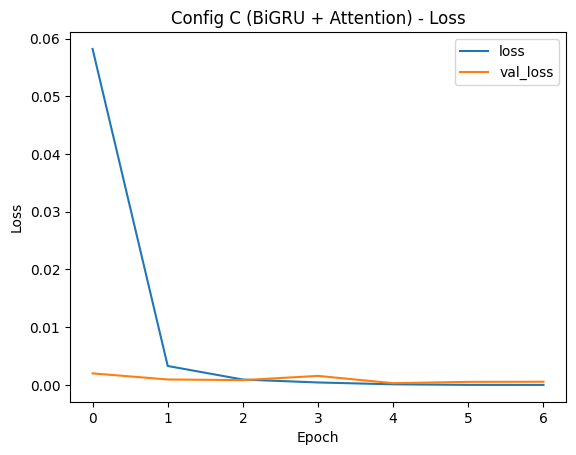

In [24]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure()
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history_A, "Config A (GRU) - Loss")
plot_history(history_B, "Config B (BiGRU) - Loss")
plot_history(history_C, "Config C (BiGRU + Attention) - Loss")


## Preprocesare text (Modelul 2)

Pentru modelul neural am folosit o preprocesare intentionat moderata (fara stemming/stopwords), deoarece embedding-urile si BiGRU pot beneficia de informatia contextuala completa.

Tehnici aplicate:
1. Concatenare `title + text` intr-un singur camp de intrare
2. Conversie la string + eliminare valori lipsa (filtrare texte goale)
3. Lowercasing
4. Eliminare URL-uri
5. Normalizare whitespace (spatii multiple)
6. Padding + truncation la lungime fixa (`MAX_LEN`)
7. Tokenizare si mapare la ID-uri (`Tokenizer`, vocab_size)
